In [22]:
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.geocoders import Nominatim
import requests
import json
import numpy as np
from api_key import map_api_key
from datetime import datetime

In [23]:
file = "Resources/house_values_by_neighborhood.csv"
house_values_by_n = pd.read_csv(file)
house_values_by_n.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2018/1/31,...,2022/5/31,2022/6/30,2022/7/31,2022/8/31,2022/9/30,2022/10/31,2022/11/30,2022/12/31,2023/1/31,2023/2/28
0,112345,0,Maryvale,neighborhood,AZ,AZ,Phoenix,"Phoenix-Mesa-Chandler, AZ",Maricopa County,1.643264e+05,...,3.222826e+05,3.278827e+05,3.313116e+05,3.319515e+05,3.298191e+05,3.264298e+05,3.222582e+05,3.177341e+05,3.136730e+05,3.100235e+05
1,274772,1,Northeast Dallas,neighborhood,TX,TX,Dallas,"Dallas-Fort Worth-Arlington, TX",Dallas County,2.930974e+05,...,4.247463e+05,4.292616e+05,4.307727e+05,4.293527e+05,4.267793e+05,4.256132e+05,4.255507e+05,4.248966e+05,4.248382e+05,4.253930e+05
2,192689,2,Paradise,neighborhood,NV,NV,Las Vegas,"Las Vegas-Henderson-Paradise, NV",Clark County,2.382273e+05,...,3.781283e+05,3.841422e+05,3.877655e+05,3.882863e+05,3.856816e+05,3.815849e+05,3.766350e+05,3.714566e+05,3.662519e+05,3.622461e+05
3,270957,3,Upper East Side,neighborhood,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,1.035609e+06,...,1.454846e+06,1.469594e+06,1.473549e+06,1.462112e+06,1.435886e+06,1.414317e+06,1.390045e+06,1.364192e+06,1.339897e+06,1.327725e+06
4,118208,4,South Los Angeles,neighborhood,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,3.820556e+05,...,6.424227e+05,6.452196e+05,6.488562e+05,6.501848e+05,6.510095e+05,6.497998e+05,6.494567e+05,6.473049e+05,6.420439e+05,6.340952e+05


In [24]:
#filter to only SF
house_values_sf = house_values_by_n[house_values_by_n['City'] == "San Francisco"].reset_index(drop=True)

house_values_sf = house_values_sf.rename(columns = {"RegionName":"Neighborhood"})
house_values_sf = house_values_sf.drop(columns=['2023/1/31','2023/2/28'])
house_values_sf.head()

,RegionID,SizeRank,Neighborhood,RegionType,StateName,State,City,Metro,CountyName,2018/1/31,...,2022/3/31,2022/4/30,2022/5/31,2022/6/30,2022/7/31,2022/8/31,2022/9/30,2022/10/31,2022/11/30,2022/12/31
0,268384,183,Outer Sunset,neighborhood,CA,CA,San Francisco,"San Francisco-Oakland-Berkeley, CA",San Francisco County,1.185295e+06,...,1.473461e+06,1.487573e+06,1.490796e+06,1.482646e+06,1.467413e+06,1.446247e+06,1.420934e+06,1.398965e+06,1.379622e+06,1.362996e+06
1,274552,282,Mission,neighborhood,CA,CA,San Francisco,"San Francisco-Oakland-Berkeley, CA",San Francisco County,1.151267e+06,...,1.241704e+06,1.243708e+06,1.240469e+06,1.228649e+06,1.211286e+06,1.188773e+06,1.165668e+06,1.144341e+06,1.125770e+06,1.108270e+06
2,268383,415,Outer Richmond,neighborhood,CA,CA,San Francisco,"San Francisco-Oakland-Berkeley, CA",San Francisco County,1.335119e+06,...,1.635760e+06,1.652124e+06,1.653770e+06,1.641899e+06,1.619682e+06,1.588574e+06,1.555373e+06,1.527587e+06,1.505795e+06,1.485441e+06
3,268491,426,South of Market,neighborhood,CA,CA,San Francisco,"San Francisco-Oakland-Berkeley, CA",San Francisco County,9.658590e+05,...,9.727997e+05,9.747926e+05,9.730468e+05,9.654191e+05,9.538103e+05,9.379651e+05,9.199094e+05,9.022131e+05,8.876197e+05,8.751248e+05
4,268219,507,Inner Richmond,neighborhood,CA,CA,San Francisco,"San Francisco-Oakland-Berkeley, CA",San Francisco County,1.754276e+06,...,2.030361e+06,2.057767e+06,2.067829e+06,2.055628e+06,2.026344e+06,1.983687e+06,1.932216e+06,1.886865e+06,1.850248e+06,1.819219e+06


In [25]:
#rename neighborhood to match name with crime dataset
rename_nei = [
    ('Alamo Square','Western Addition'),
    ('Anza Vista','Western Addition'),
    ('Aquatic Park','Presidio'),
    ('Ashbury Heights','Haight Ashbury'),
    ('Balboa Terrace','West of Twin Peaks'),
    ('Bayview','Bayview Hunters Point'),
    ('Bernal Heights','Bernal Heights'),
    ('Bret Harte','Bayview Hunters Point'),
    ('Buena Vista','Haight Ashbury'),
    ('Candlestick Point SRA','Bayview Hunters Point'),
    ('Castro','Castro /Upper Market'),
    ('Cathedral Hill','Western Addition'),
    ('Cayuga','Excelsior'),
    ('Central Waterfront','Potrero Hill'),
    ('Chinatown','Chinatown'),
    ('Civic Center','Tenderloin'),
    ('Clarendon Heights','Twin Peaks'),
    ('Cole Valley','Haight Ashbury'),
    ('Corona Heights','Haight Ashbury'),
    ('Cow Hollow','Marina'),
    ('Crocker Amazon','Excelsior'),
    ('Diamond Heights','Twin Peaks'),
    ('Dogpatch','Potrero Hill'),
    ('Dolores Heights','Castro /Upper Market'),
    ('Downtown','Financial District/South Beach'),
    ('Duboce Triangle','Haight Ashbury'),
    ('Eureka Valley','Castro /Upper Market'),
    ('Excelsior','Excelsior'),
    ('Financial District','Financial District/South Beach'),
    ("Fisherman's Wharf",'North Beach'),
    ('Forest Hill','West of Twin Peaks'),
    ('Forest Knolls','Sunset /Parkside'),
    ('Glen Park','Glen Park'),
    ('Golden Gate Heights','Inner Sunset'),
    ('Haight','Haight Ashbury'),
    ('Hayes Valley','Hayes Valley'),
    ('Holly Park','Bernal Heights'),
    ('Hunters Point','Bayview Hunters Point'),
    ('Ingleside','Oceanview/Merced/Ingleside'),
    ('Ingleside Heights','Oceanview/Merced/Ingleside'),
    ('Ingleside Terrace','West of Twin Peaks'),
    ('Inner Richmond','Inner Richmond'),
    ('Inner Sunset','Inner Sunset'),
    ('Japantown','Japantown'),
    ('Laguna Honda','Twin Peaks'),
    ('Lake','Outer Richmond'),
    ('Lake Street','Outer Richmond'),
    ('Lakeshore','Lakeshore'),
    ('Laurel Heights','Inner Richmond'),
    ('Little Hollywood','Bayview Hunters Point'),
    ('Lone Mountain','Lone Mountain/USF'),
    ('Lower Haight','Haight Ashbury'),
    ('Lower Nob Hill','Nob Hill'),
    ('Lower Pacific Heights','Pacific Heights'),
    ('Marina','Marina'),
    ('Merced Manor','Oceanview/Merced/Ingleside'),
    ('Midtown Terrace','West of Twin Peaks'),
    ('Mint Hill','Twin Peaks'),
    ('Miraloma Park','West of Twin Peaks'),
    ('Mission','Mission'),
    ('Mission Bay','Mission Bay'),
    ('Mission Dolores','Mission'),
    ('Mission Terrace','Outer Mission'),
    ('Monterey Heights','West of Twin Peaks'),
    ('Mount Davidson Manor','West of Twin Peaks'),
    ('Nob Hill','Nob Hill'),
    ('Noe Valley','Noe Valley'),
    ('North Beach','North Beach'),
    ('North Waterfront','North Beach'),
    ('Oceanview','Oceanview/Merced/Ingleside'),
    ('Outer Mission','Outer Mission'),
    ('Outer Richmond','Outer Richmond'),
    ('Outer Sunset','Sunset /Parkside'),
    ('Pacific Heights','Pacific Heights'),
    ('Panhandle','Haight Ashbury'),
    ('Parkmerced','Lakeshore'),
    ('Parkside','Sunset /Parkside'),
    ('Parnassus Heights','Twin Peaks'),
    ('Peralta Heights','Bernal Heights'),
    ('Polk Gulch','Tenderloin'),
    ('Portola','Portola'),
    ('Potrero Hill','Potrero Hill'),
    ('Presidio','Presidio'),
    ('Presidio Heights','Presidio Heights'),
    ('Rincon Hill','Financial District/South Beach'),
    ('Russian Hill','Russian Hill'),
    ('Seacliff','Seacliff'),
    ('Sherwood Forest','West of Twin Peaks'),
    ('Showplace Square','Potrero Hill'),
    ('Silver Terrace','Bayview Hunters Point'),
    ('South Beach','Financial District/South Beach'),
    ('South of Market','South of Market'),
    ('St. Francis Wood','West of Twin Peaks'),
    ('St. Marys Park','Bernal Heights'),
    ('Stonestown','Lakeshore'),
    ('Sunnydale','Visitacion Valley'),
    ('Sunnyside','Glen Park'),
    ('Sutro Heights','Outer Richmond'),
    ('Telegraph Hill','North Beach'),
    ('Tenderloin','Tenderloin'),
    ('Union Street','Russian Hill'),
    ('University Mound','Portola'),
    ('Upper Market','Castro /Upper Market'),
    ('Visitacion Valley','Visitacion Valley'),
    ('West Portal','West of Twin Peaks'),
    ('Western Addition','Western Addition'),
    ('Westwood Highlands','West of Twin Peaks'),
    ('Westwood Park','West of Twin Peaks')
]

for i in rename_nei:
    house_values_sf=house_values_sf.replace(i[0], i[1])

house_values_sf.head()

,RegionID,SizeRank,Neighborhood,RegionType,StateName,State,City,Metro,CountyName,2018/1/31,...,2022/3/31,2022/4/30,2022/5/31,2022/6/30,2022/7/31,2022/8/31,2022/9/30,2022/10/31,2022/11/30,2022/12/31
0,268384,183,Sunset /Parkside,neighborhood,CA,CA,San Francisco,"San Francisco-Oakland-Berkeley, CA",San Francisco County,1.185295e+06,...,1.473461e+06,1.487573e+06,1.490796e+06,1.482646e+06,1.467413e+06,1.446247e+06,1.420934e+06,1.398965e+06,1.379622e+06,1.362996e+06
1,274552,282,Mission,neighborhood,CA,CA,San Francisco,"San Francisco-Oakland-Berkeley, CA",San Francisco County,1.151267e+06,...,1.241704e+06,1.243708e+06,1.240469e+06,1.228649e+06,1.211286e+06,1.188773e+06,1.165668e+06,1.144341e+06,1.125770e+06,1.108270e+06
2,268383,415,Outer Richmond,neighborhood,CA,CA,San Francisco,"San Francisco-Oakland-Berkeley, CA",San Francisco County,1.335119e+06,...,1.635760e+06,1.652124e+06,1.653770e+06,1.641899e+06,1.619682e+06,1.588574e+06,1.555373e+06,1.527587e+06,1.505795e+06,1.485441e+06
3,268491,426,South of Market,neighborhood,CA,CA,San Francisco,"San Francisco-Oakland-Berkeley, CA",San Francisco County,9.658590e+05,...,9.727997e+05,9.747926e+05,9.730468e+05,9.654191e+05,9.538103e+05,9.379651e+05,9.199094e+05,9.022131e+05,8.876197e+05,8.751248e+05
4,268219,507,Inner Richmond,neighborhood,CA,CA,San Francisco,"San Francisco-Oakland-Berkeley, CA",San Francisco County,1.754276e+06,...,2.030361e+06,2.057767e+06,2.067829e+06,2.055628e+06,2.026344e+06,1.983687e+06,1.932216e+06,1.886865e+06,1.850248e+06,1.819219e+06


In [26]:
#normalize the date
date_string = [ '2018/1/31',
 '2018/2/28',
 '2018/3/31',
 '2018/4/30',
 '2018/5/31',
 '2018/6/30',
 '2018/7/31',
 '2018/8/31',
 '2018/9/30',
 '2018/10/31',
 '2018/11/30',
 '2018/12/31',
 '2019/1/31',
 '2019/2/28',
 '2019/3/31',
 '2019/4/30',
 '2019/5/31',
 '2019/6/30',
 '2019/7/31',
 '2019/8/31',
 '2019/9/30',
 '2019/10/31',
 '2019/11/30',
 '2019/12/31',
 '2020/1/31',
 '2020/2/29',
 '2020/3/31',
 '2020/4/30',
 '2020/5/31',
 '2020/6/30',
 '2020/7/31',
 '2020/8/31',
 '2020/9/30',
 '2020/10/31',
 '2020/11/30',
 '2020/12/31',
 '2021/1/31',
 '2021/2/28',
 '2021/3/31',
 '2021/4/30',
 '2021/5/31',
 '2021/6/30',
 '2021/7/31',
 '2021/8/31',
 '2021/9/30',
 '2021/10/31',
 '2021/11/30',
 '2021/12/31',
 '2022/1/31',
 '2022/2/28',
 '2022/3/31',
 '2022/4/30',
 '2022/5/31',
 '2022/6/30',
 '2022/7/31',
 '2022/8/31',
 '2022/9/30',
 '2022/10/31',
 '2022/11/30',
 '2022/12/31']

norm_date=[]
for i in date_string:
    date_obj = datetime.strptime(i, "%Y/%m/%d")
    formatted_date = date_obj.strftime("%Y-%m")
    norm_date.append(formatted_date) 
#norm_date

In [27]:
for i, j in zip(date_string, norm_date):
    house_values_sf = house_values_sf.rename(columns={i:j})
house_values_sf['Neighborhood'].nunique()

37

In [28]:
house_values_neighbor = house_values_sf.groupby('Neighborhood').mean([norm_date])
house_values_neighbor = house_values_neighbor.drop(columns=['RegionID', 'SizeRank'])
house_values_neighbor.to_csv('Outputs/house_values_neighbor_reg.csv')
house_values_neighbor.head()

,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,...,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Bayview Hunters Point,8.313694e+05,8.368342e+05,8.423898e+05,8.467867e+05,8.547810e+05,8.635056e+05,8.706263e+05,8.738061e+05,8.756304e+05,8.782031e+05,...,9.428216e+05,9.465809e+05,9.470455e+05,9.423044e+05,9.332540e+05,9.197236e+05,9.030775e+05,8.877731e+05,8.736689e+05,8.606945e+05
Bernal Heights,1.375103e+06,1.387180e+06,1.399212e+06,1.408955e+06,1.423618e+06,1.435918e+06,1.438417e+06,1.434586e+06,1.430127e+06,1.431057e+06,...,1.544773e+06,1.551735e+06,1.550538e+06,1.539318e+06,1.519911e+06,1.491201e+06,1.456723e+06,1.427157e+06,1.402188e+06,1.380843e+06
Castro /Upper Market,1.654890e+06,1.665722e+06,1.674729e+06,1.682073e+06,1.695479e+06,1.710667e+06,1.713891e+06,1.710233e+06,1.704266e+06,1.704678e+06,...,1.838399e+06,1.850473e+06,1.854108e+06,1.843518e+06,1.820630e+06,1.782846e+06,1.739188e+06,1.698651e+06,1.666802e+06,1.638838e+06
Chinatown,9.320361e+05,9.371647e+05,9.422865e+05,9.475125e+05,9.569437e+05,9.656823e+05,9.702448e+05,9.703943e+05,9.680536e+05,9.682619e+05,...,1.017680e+06,1.009113e+06,1.000575e+06,9.880765e+05,9.706678e+05,9.508425e+05,9.308357e+05,9.147687e+05,9.052877e+05,9.003025e+05
Excelsior,9.719333e+05,9.802134e+05,9.877608e+05,9.954650e+05,1.006300e+06,1.016091e+06,1.020471e+06,1.019138e+06,1.015312e+06,1.015029e+06,...,1.147139e+06,1.156628e+06,1.159803e+06,1.155353e+06,1.144145e+06,1.127007e+06,1.106722e+06,1.088557e+06,1.072309e+06,1.057309e+06


In [29]:
#get yearly average house values and a column for avg values over 2018-2023
col_2018 = ['2018-01',
 '2018-02',
 '2018-03',
 '2018-04',
 '2018-05',
 '2018-06',
 '2018-07',
 '2018-08',
 '2018-09',
 '2018-10',
 '2018-11',
 '2018-12']
col_2019 = ['2019-01',
 '2019-02',
 '2019-03',
 '2019-04',
 '2019-05',
 '2019-06',
 '2019-07',
 '2019-08',
 '2019-09',
 '2019-10',
 '2019-11',
 '2019-12']
col_2020 = ['2020-01',
 '2020-02',
 '2020-03',
 '2020-04',
 '2020-05',
 '2020-06',
 '2020-07',
 '2020-08',
 '2020-09',
 '2020-10',
 '2020-11',
 '2020-12']
col_2021 = ['2021-01',
 '2021-02',
 '2021-03',
 '2021-04',
 '2021-05',
 '2021-06',
 '2021-07',
 '2021-08',
 '2021-09',
 '2021-10',
 '2021-11',]
col_2022 = ['2022-01',
 '2022-02',
 '2022-03',
 '2022-04',
 '2022-05',
 '2022-06',
 '2022-07',
 '2022-08',
 '2022-09',
 '2022-10',
 '2022-11',
 '2022-12']


house_values_2018 = house_values_neighbor[col_2018]
house_values_2019 = house_values_neighbor[col_2019]
house_values_2020 = house_values_neighbor[col_2020]
house_values_2021 = house_values_neighbor[col_2021]
house_values_2022 = house_values_neighbor[col_2022]


house_values_2018_mean = house_values_2018.mean(axis=1)
house_values_2019_mean = house_values_2019.mean(axis=1)
house_values_2020_mean = house_values_2020.mean(axis=1)
house_values_2021_mean = house_values_2021.mean(axis=1)
house_values_2022_mean = house_values_2022.mean(axis=1)



house_values_year = pd.DataFrame({'2018': house_values_2018_mean,
                                  '2019': house_values_2019_mean,
                                  '2020': house_values_2020_mean,
                                  '2021': house_values_2021_mean,
                                  '2022': house_values_2022_mean})

house_values_year['avg house value 2018-2022'] = house_values_year.mean(axis=1)
house_values_year

,2018,2019,2020,2021,2022,avg house value 2018-2022
Neighborhood,,,,,,
Bayview Hunters Point,8.612809e+05,8.841494e+05,9.095717e+05,9.169119e+05,9.193355e+05,8.982499e+05
Bernal Heights,1.418547e+06,1.408617e+06,1.446734e+06,1.469301e+06,1.493485e+06,1.447337e+06
Castro /Upper Market,1.693869e+06,1.701151e+06,1.735675e+06,1.726517e+06,1.781344e+06,1.727711e+06
Chinatown,9.580638e+05,9.811526e+05,9.925228e+05,1.001899e+06,9.729544e+05,9.813186e+05
Excelsior,1.004737e+06,1.018673e+06,1.066233e+06,1.097346e+06,1.122979e+06,1.061994e+06
Financial District/South Beach,1.079584e+06,1.085363e+06,1.075695e+06,1.070488e+06,1.096068e+06,1.081440e+06
Glen Park,1.453699e+06,1.438171e+06,1.460773e+06,1.494537e+06,1.549414e+06,1.479319e+06
Haight Ashbury,1.566304e+06,1.589929e+06,1.612448e+06,1.626496e+06,1.690522e+06,1.617140e+06
Hayes Valley,1.167704e+06,1.176818e+06,1.183933e+06,1.145156e+06,1.157986e+06,1.166320e+06


In [30]:
#highest hosue value by neighborhood
house_values_year['avg house value 2018-2022'].sort_values(ascending=False).head()

Neighborhood
Presidio Heights      3.843441e+06
Seacliff              3.517686e+06
Marina                2.323277e+06
Inner Richmond        2.044559e+06
West of Twin Peaks    1.925200e+06
Name: avg house value 2018-2022, dtype: float64

In [31]:
#lowest hosue value by neighborhood
house_values_year['avg house value 2018-2022'].sort_values(ascending=True).head()

Neighborhood
Tenderloin               860336.933117
Visitacion Valley        886341.738060
Bayview Hunters Point    898249.900496
Potrero Hill             962165.028936
South of Market          964289.818592
Name: avg house value 2018-2022, dtype: float64

In [32]:
house_trans = house_values_year.drop(columns=['avg house value 2018-2022']).T
house_trans

Neighborhood,Bayview Hunters Point,Bernal Heights,Castro /Upper Market,Chinatown,Excelsior,Financial District/South Beach,Glen Park,Haight Ashbury,Hayes Valley,Inner Richmond,...,Presidio Heights,Russian Hill,Seacliff,South of Market,Sunset /Parkside,Tenderloin,Twin Peaks,Visitacion Valley,West of Twin Peaks,Western Addition
2018,861280.907957,1.418547e+06,1.693869e+06,9.580638e+05,1.004737e+06,1.079584e+06,1.453699e+06,1.566304e+06,1.167704e+06,1.982911e+06,...,3.783715e+06,1.635272e+06,3.371306e+06,977192.753750,1.331057e+06,883600.324611,1.498699e+06,827366.793500,1.855051e+06,1.055791e+06
2019,884149.431257,1.408617e+06,1.701151e+06,9.811526e+05,1.018673e+06,1.085363e+06,1.438171e+06,1.589929e+06,1.176818e+06,1.943290e+06,...,3.690169e+06,1.628061e+06,3.313852e+06,979033.688283,1.338946e+06,873922.677992,1.432029e+06,842878.214667,1.843144e+06,1.071409e+06
2020,909571.729278,1.446734e+06,1.735675e+06,9.925228e+05,1.066233e+06,1.075695e+06,1.460773e+06,1.612448e+06,1.183933e+06,2.001747e+06,...,3.698220e+06,1.623719e+06,3.381367e+06,974572.559575,1.391839e+06,864364.318406,1.465159e+06,888305.616742,1.894628e+06,1.091835e+06
2021,916911.934506,1.469301e+06,1.726517e+06,1.001899e+06,1.097346e+06,1.070488e+06,1.494537e+06,1.626496e+06,1.145156e+06,2.077583e+06,...,3.847897e+06,1.632994e+06,3.602184e+06,949226.940736,1.470788e+06,842788.695070,1.515830e+06,916715.671782,1.966882e+06,1.094043e+06
2022,919335.499481,1.493485e+06,1.781344e+06,9.729544e+05,1.122979e+06,1.096068e+06,1.549414e+06,1.690522e+06,1.157986e+06,2.217263e+06,...,4.197205e+06,1.688693e+06,3.919720e+06,941423.150617,1.538775e+06,837008.649508,1.580528e+06,956442.393608,2.066297e+06,1.113912e+06


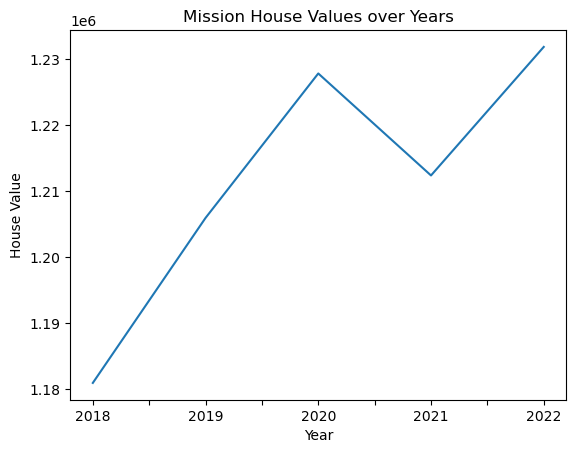

In [33]:
#create a function that can visualize the house value change over years by selected neighborhood
neighborhood = []
for i in house_values_year.index:
    neighborhood.append(i)
    
def neighbor_house_chart(name):
    for i in neighborhood:
        if i == name:
            house_trans[i].plot()
            plt.xlabel('Year')
            plt.ylabel('House Value')
            plt.title(f'{i} House Values over Years')
            plt.show()

neighbor_house_chart('Mission')

In [34]:
house_values_all_year = house_values_year['avg house value 2018-2022']
house_values_all_year = pd.DataFrame(house_values_all_year)
house_values_all_year.sort_values('avg house value 2018-2022')

,avg house value 2018-2022
Neighborhood,
Tenderloin,8.603369e+05
Visitacion Valley,8.863417e+05
Bayview Hunters Point,8.982499e+05
Potrero Hill,9.621650e+05
South of Market,9.642898e+05
Chinatown,9.813186e+05
Japantown,1.013877e+06
Portola,1.045076e+06
Excelsior,1.061994e+06


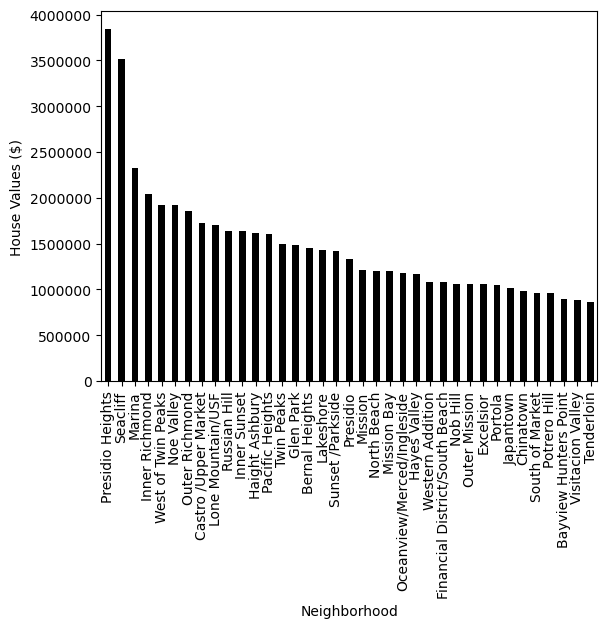

In [46]:
house_values_all_year.sort_values('avg house value 2018-2022',ascending=False).plot(kind='bar', legend=None, color='black')
#plt.title('Average House Values in SF by Neighborhood 2018-2022')
plt.ylabel('House Values ($)')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
#plt.subplots_adjust(bottom=0.46, left=0.15)
#plt.savefig('Outputs/images/Average House Values by Neighborhood in SF 2018-2022.jpg')
plt.show()

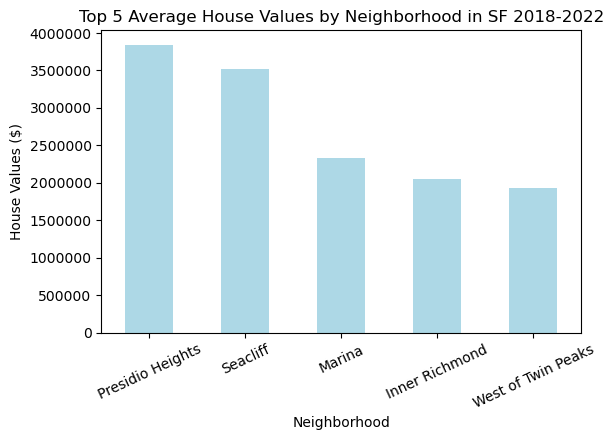

In [98]:
house_values_all_year.sort_values('avg house value 2018-2022',ascending=False).head().plot(kind='bar', legend=None, color='lightblue')
plt.title('Top 5 Average House Values by Neighborhood in SF 2018-2022')
plt.ylabel('House Values ($)')
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Top 5 Average House Values by Neighborhood in SF 2018-2022.jpg')
plt.show()

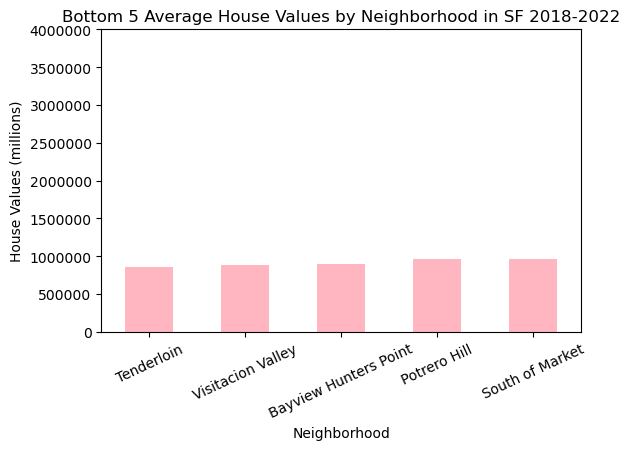

In [99]:
house_values_all_year.sort_values('avg house value 2018-2022',ascending=True).head().plot(kind='bar', legend=None, color='lightpink')
plt.title('Bottom 5 Average House Values by Neighborhood in SF 2018-2022')
plt.ylabel('House Values (millions)')
plt.ylim(0,4000000)
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Bottom 5 Average House Values by Neighborhood in SF 2018-2022.jpg')
plt.show()

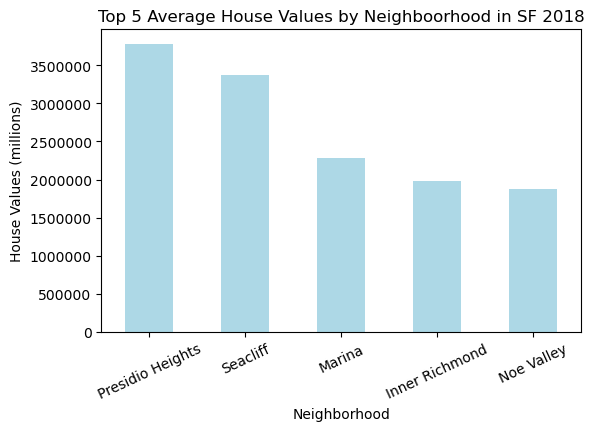

In [101]:
house_values_year['2018'].sort_values(ascending=False).head().plot(kind='bar',color='lightblue')
plt.title('Top 5 Average House Values by Neighboorhood in SF 2018')
plt.ylabel('House Values (millions)')
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Top 5 Average House Values by Neighborhood in SF 2018.jpg')
plt.show()

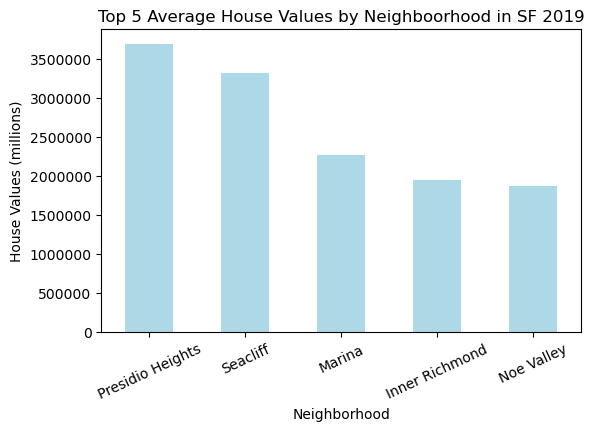

In [102]:
house_values_year['2019'].sort_values(ascending=False).head().plot(kind='bar',color='lightblue')
plt.title('Top 5 Average House Values by Neighboorhood in SF 2019')
plt.ylabel('House Values (millions)')
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Top 5 Average House Values by Neighborhood in SF 2019.jpg')
plt.show()

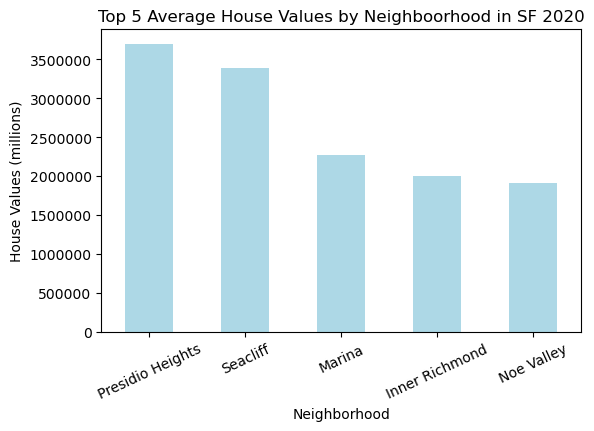

In [103]:
house_values_year['2020'].sort_values(ascending=False).head().plot(kind='bar',color='lightblue')
plt.title('Top 5 Average House Values by Neighboorhood in SF 2020')
plt.ylabel('House Values (millions)')
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Top 5 Average House Values by Neighborhood in SF 2020.jpg')
plt.show()

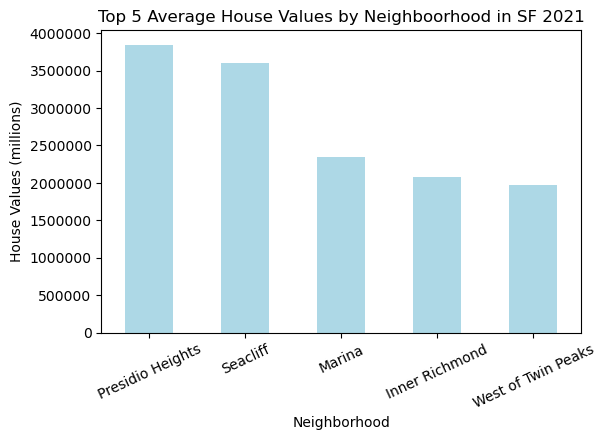

In [104]:
house_values_year['2021'].sort_values(ascending=False).head().plot(kind='bar',color='lightblue')
plt.title('Top 5 Average House Values by Neighboorhood in SF 2021')
plt.ylabel('House Values (millions)')
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Top 5 Average House Values by Neighborhood in SF 2021.jpg')
plt.show()

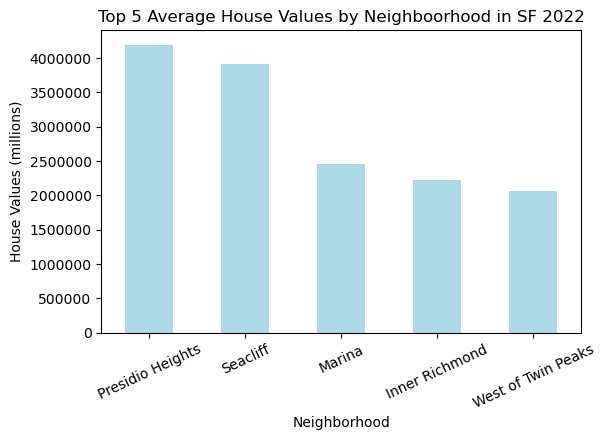

In [105]:
house_values_year['2022'].sort_values(ascending=False).head().plot(kind='bar',color='lightblue')
plt.title('Top 5 Average House Values by Neighboorhood in SF 2022')
plt.ylabel('House Values (millions)')
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Top 5 Average House Values by Neighborhood in SF 2022.jpg')
plt.show()

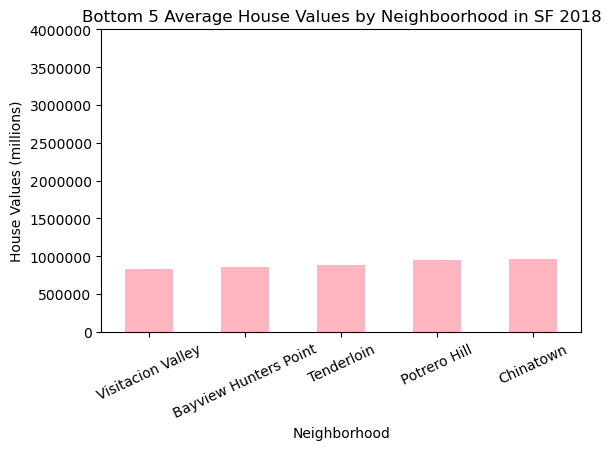

In [106]:
house_values_year['2018'].sort_values(ascending=True).head().plot(kind='bar',color='lightpink')
plt.title('Bottom 5 Average House Values by Neighboorhood in SF 2018')
plt.ylabel('House Values (millions)')
plt.ylim(0,4000000)
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Bottom 5 Average House Values by Neighborhood in SF 2018.jpg')
plt.show()

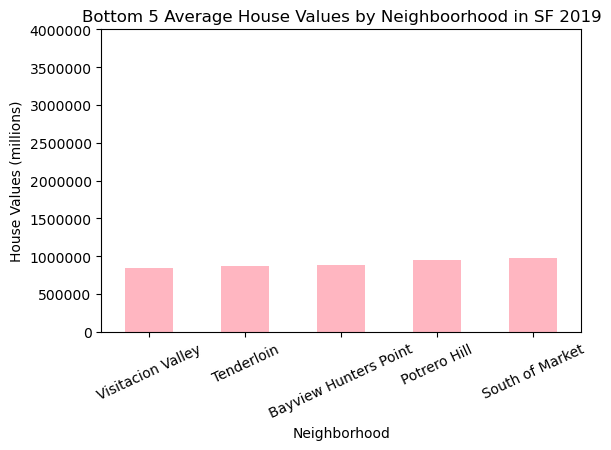

In [107]:
house_values_year['2019'].sort_values(ascending=True).head().plot(kind='bar',color='lightpink')
plt.title('Bottom 5 Average House Values by Neighboorhood in SF 2019')
plt.ylabel('House Values (millions)')
plt.ylim(0,4000000)
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Bottom 5 Average House Values by Neighborhood in SF 2019.jpg')
plt.show()

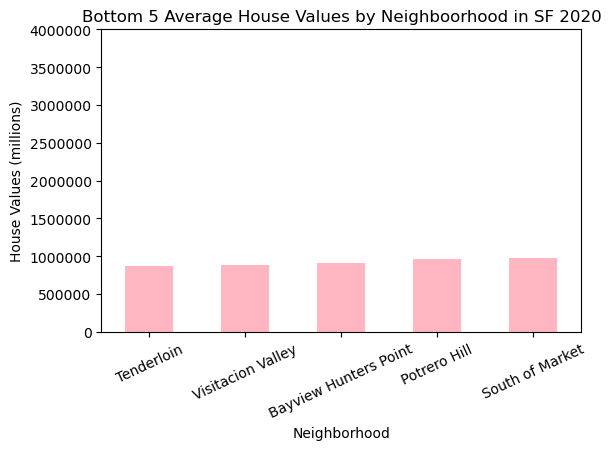

In [108]:
house_values_year['2020'].sort_values(ascending=True).head().plot(kind='bar',color='lightpink')
plt.title('Bottom 5 Average House Values by Neighboorhood in SF 2020')
plt.ylabel('House Values (millions)')
plt.ylim(0,4000000)
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Bottom 5 Average House Values by Neighborhood in SF 2020.jpg')
plt.show()

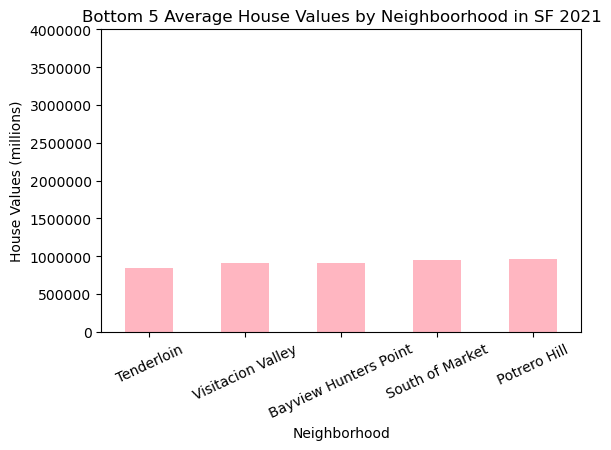

In [109]:
house_values_year['2021'].sort_values(ascending=True).head().plot(kind='bar',color='lightpink')
plt.title('Bottom 5 Average House Values by Neighboorhood in SF 2021')
plt.ylabel('House Values (millions)')
plt.ylim(0,4000000)
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Bottom 5 Average House Values by Neighborhood in SF 2021.jpg')
plt.show()

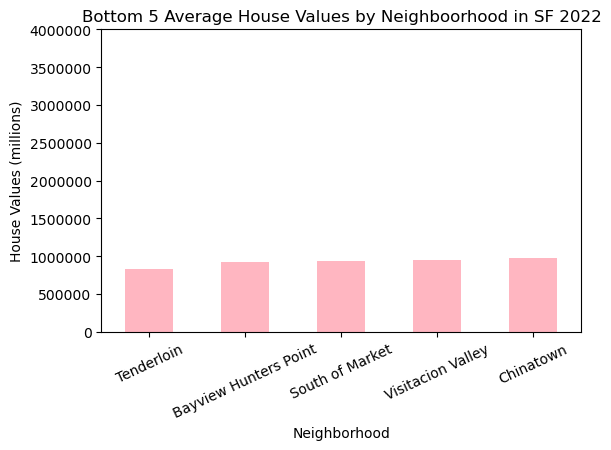

In [110]:
house_values_year['2022'].sort_values(ascending=True).head().plot(kind='bar',color='lightpink')
plt.title('Bottom 5 Average House Values by Neighboorhood in SF 2022')
plt.ylabel('House Values (millions)')
plt.ylim(0,4000000)
plt.xticks(rotation=25)
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(bottom=0.25, left=0.15)
plt.savefig('Outputs/images/Bottom 5 Average House Values by Neighborhood in SF 2022.jpg')
plt.show()